In [ ]:
import os
import zipfile
import torch
import torch.nn as nn
import time
import math
import matplotlib.pyplot as plt
from collections import Counter

from google.colab import drive

drive.mount('/content/drive')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Data Processing

def read_and_process_file(filename):
    data = []
    with open(filename, 'r') as f:
        for line in f:
            tokens = line.strip().split() + ['<eos>']
            data.extend(tokens)
    return data

def load_data(data_path):
    with zipfile.ZipFile(data_path, 'r') as zip_ref:
        zip_ref.extractall('./data/ptb')

    train_data = read_and_process_file('./data/ptb/ptb_data/ptb.train.txt')
    valid_data = read_and_process_file('./data/ptb/ptb_data/ptb.valid.txt')
    test_data = read_and_process_file('./data/ptb/ptb_data/ptb.test.txt')

    counter = Counter(train_data)
    count_pairs = sorted(counter.items(), key=lambda x: (-x[1], x[0]))
    words, _ = list(zip(*count_pairs))
    word_to_id = {word: i for i, word in enumerate(words)}
    id_to_word = {i: word for i, word in enumerate(words)}
    vocab_size = len(word_to_id)

    def tokens_to_ids(tokens):
        return [word_to_id[word] for word in tokens]

    train_data_ids = tokens_to_ids(train_data)
    valid_data_ids = tokens_to_ids(valid_data)
    test_data_ids = tokens_to_ids(test_data)

    return train_data_ids, valid_data_ids, test_data_ids, vocab_size

def batchify(data_ids, batch_size):
    nbatch = len(data_ids) // batch_size
    data_ids = data_ids[:nbatch * batch_size]
    data = torch.tensor(data_ids, dtype=torch.long).to(device)
    data = data.view(batch_size, -1).t().contiguous()
    return data

def get_batch(source, i, seq_len):
    seq_len = min(seq_len, source.size(0) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len]
    return data, target.reshape(-1)

import argparse
import time
import math

# Hyperparameters and settings
batch_size = 20
eval_batch_size = 10
seq_len = 20
embedding_dim = 200
hidden_dim = 200
num_layers = 2
epochs = 25
clip = 0.25
data_path = '/content/drive/MyDrive/Deep Learning/ex2_ed568_ac2975/ptb_data.zip' # Need to upload to data folder if reset

# Load data
train_data_ids, valid_data_ids, test_data_ids, vocab_size = load_data(data_path)
train_data = batchify(train_data_ids, batch_size)
valid_data = batchify(valid_data_ids, eval_batch_size)
test_data = batchify(test_data_ids, eval_batch_size)

In [ ]:
# RNN Model Architecture
class RNNModel(nn.Module):
    def __init__(self, rnn_type, vocab_size, embedding_dim, hidden_dim, num_layers, dropout):
        super(RNNModel, self).__init__()
        self.drop = nn.Dropout(dropout)
        self.encoder = nn.Embedding(vocab_size, embedding_dim)
        if rnn_type == 'LSTM':
            self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers, dropout=dropout)
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers, dropout=dropout)
        else:
            raise ValueError("Invalid rnn_type")
        self.decoder = nn.Linear(hidden_dim, vocab_size)

        self.init_weights()
        self.rnn_type = rnn_type
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

    def init_weights(self):
        initrange = 0.1
        nn.init.uniform_(self.encoder.weight, -initrange, initrange)
        nn.init.zeros_(self.decoder.bias)
        nn.init.uniform_(self.decoder.weight, -initrange, initrange)

    def forward(self, input, hidden):
        emb = self.drop(self.encoder(input))
        output, hidden = self.rnn(emb, hidden)
        output = self.drop(output)
        output = output.reshape(-1, self.hidden_dim)
        decoded = self.decoder(output)
        return decoded, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters())
        if self.rnn_type == 'LSTM':
            return (weight.new_zeros(self.num_layers, batch_size, self.hidden_dim).to(device),
                    weight.new_zeros(self.num_layers, batch_size, self.hidden_dim).to(device))
        else:
            return weight.new_zeros(self.num_layers, batch_size, self.hidden_dim).to(device)

def repackage_hidden(h):
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

In [ ]:
# Training

def train(model, train_data, criterion, optimizer, epoch, seq_len, lr):
    model.train()
    total_loss = 0.
    start_time = time.time()
    hidden = model.init_hidden(batch_size)
    batch_losses = []
    for batch, i in enumerate(range(0, train_data.size(0) - 1, seq_len)):
        data, targets = get_batch(train_data, i, seq_len)
        hidden = repackage_hidden(hidden)
        optimizer.zero_grad()
        output, hidden = model(data, hidden)
        loss = criterion(output, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.25)
        optimizer.step()
        total_loss += loss.item()
        batch_losses.append(loss.item())

        if batch % 200 == 0 and batch > 0:
            cur_loss = total_loss / 200
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.2f} | ms/batch {:5.2f} | '
                  'loss {:5.2f} | ppl {:8.2f}'.format(
                    epoch, batch, train_data.size(0) // seq_len, lr,
                    elapsed * 1000 / 200, cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()
    return batch_losses

In [ ]:
# Evaluation

def evaluate(model, data_source, criterion, seq_len):
    model.eval()
    total_loss = 0.
    hidden = model.init_hidden(eval_batch_size)
    count = 0
    with torch.no_grad():
        for i in range(0, data_source.size(0) - 1, seq_len):
            count += 1
            data, targets = get_batch(data_source, i, seq_len)
            output, hidden = model(data, hidden)
            output_flat = output
            total_loss += len(data) * criterion(output_flat, targets).item()
            hidden = repackage_hidden(hidden)
    print(count,(len(data_source) - 1))
    return total_loss / (len(data_source) - 1)

In [ ]:
def plot_perplexity(train_ppls, val_ppls, title):
    epochs = range(1, len(train_ppls) + 1)
    plt.figure()
    plt.plot(epochs, train_ppls, label='Train Perplexity')
    plt.plot(epochs, val_ppls, label='Validation Perplexity')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Perplexity')
    plt.legend()
    plt.show()


Starting experiment: LSTM without Dropout
| epoch   1 |   200/ 2323 batches | lr 4.00 | ms/batch  9.38 | loss  6.97 | ppl  1065.10
| epoch   1 |   400/ 2323 batches | lr 4.00 | ms/batch  3.41 | loss  6.68 | ppl   794.63
| epoch   1 |   600/ 2323 batches | lr 4.00 | ms/batch  3.37 | loss  6.62 | ppl   749.95
| epoch   1 |   800/ 2323 batches | lr 4.00 | ms/batch  3.38 | loss  6.52 | ppl   676.75
| epoch   1 |  1000/ 2323 batches | lr 4.00 | ms/batch  3.37 | loss  6.36 | ppl   578.53
| epoch   1 |  1200/ 2323 batches | lr 4.00 | ms/batch  3.33 | loss  6.25 | ppl   518.39
| epoch   1 |  1400/ 2323 batches | lr 4.00 | ms/batch  3.39 | loss  6.06 | ppl   428.72
| epoch   1 |  1600/ 2323 batches | lr 4.00 | ms/batch  3.46 | loss  6.00 | ppl   404.39
| epoch   1 |  1800/ 2323 batches | lr 4.00 | ms/batch  3.40 | loss  5.95 | ppl   383.97
| epoch   1 |  2000/ 2323 batches | lr 4.00 | ms/batch  3.64 | loss  5.84 | ppl   342.92
| epoch   1 |  2200/ 2323 batches | lr 4.00 | ms/batch  3.50 | loss

<ipython-input-8-2ec4358dfa49>:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))


413 8242
| End of training | test loss  4.80 | test ppl   121.67


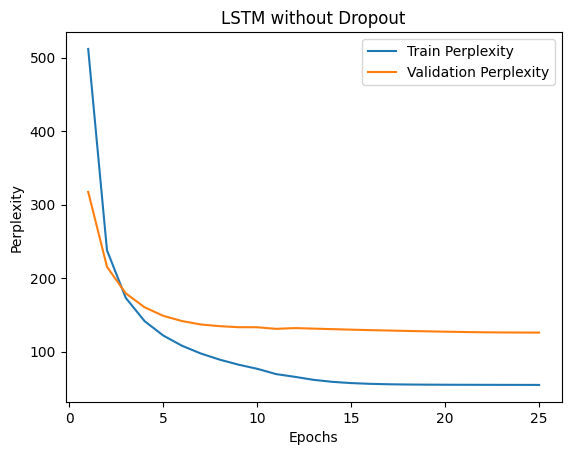


Starting experiment: LSTM with Dropout
| epoch   1 |   200/ 2323 batches | lr 6.00 | ms/batch  3.98 | loss  7.00 | ppl  1100.54
| epoch   1 |   400/ 2323 batches | lr 6.00 | ms/batch  3.54 | loss  6.66 | ppl   781.34
| epoch   1 |   600/ 2323 batches | lr 6.00 | ms/batch  3.47 | loss  6.47 | ppl   647.46
| epoch   1 |   800/ 2323 batches | lr 6.00 | ms/batch  3.47 | loss  6.32 | ppl   558.28
| epoch   1 |  1000/ 2323 batches | lr 6.00 | ms/batch  3.49 | loss  6.20 | ppl   490.42
| epoch   1 |  1200/ 2323 batches | lr 6.00 | ms/batch  3.56 | loss  6.12 | ppl   456.92
| epoch   1 |  1400/ 2323 batches | lr 6.00 | ms/batch  3.56 | loss  5.95 | ppl   382.07
| epoch   1 |  1600/ 2323 batches | lr 6.00 | ms/batch  3.53 | loss  5.89 | ppl   362.41
| epoch   1 |  1800/ 2323 batches | lr 6.00 | ms/batch  3.54 | loss  5.87 | ppl   353.02
| epoch   1 |  2000/ 2323 batches | lr 6.00 | ms/batch  3.60 | loss  5.76 | ppl   316.58
| epoch   1 |  2200/ 2323 batches | lr 6.00 | ms/batch  3.65 | loss  5

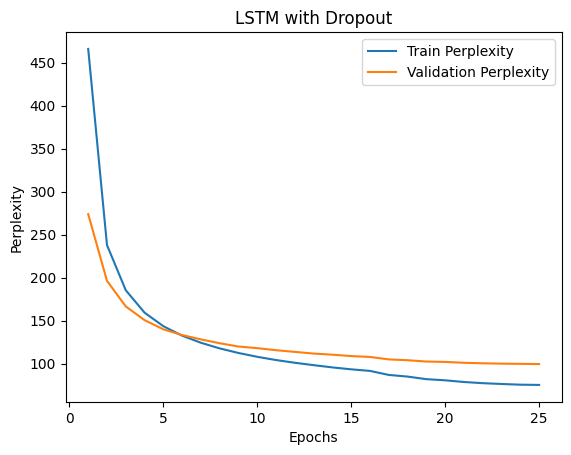


Starting experiment: GRU without Dropout
| epoch   1 |   200/ 2323 batches | lr 4.00 | ms/batch  3.22 | loss  7.00 | ppl  1092.94
| epoch   1 |   400/ 2323 batches | lr 4.00 | ms/batch  3.26 | loss  6.58 | ppl   722.36
| epoch   1 |   600/ 2323 batches | lr 4.00 | ms/batch  3.20 | loss  6.31 | ppl   550.51
| epoch   1 |   800/ 2323 batches | lr 4.00 | ms/batch  3.17 | loss  6.17 | ppl   477.73
| epoch   1 |  1000/ 2323 batches | lr 4.00 | ms/batch  3.19 | loss  6.00 | ppl   405.40
| epoch   1 |  1200/ 2323 batches | lr 4.00 | ms/batch  3.20 | loss  5.90 | ppl   364.76
| epoch   1 |  1400/ 2323 batches | lr 4.00 | ms/batch  3.17 | loss  5.71 | ppl   300.94
| epoch   1 |  1600/ 2323 batches | lr 4.00 | ms/batch  3.20 | loss  5.66 | ppl   287.06
| epoch   1 |  1800/ 2323 batches | lr 4.00 | ms/batch  3.16 | loss  5.64 | ppl   281.07
| epoch   1 |  2000/ 2323 batches | lr 4.00 | ms/batch  3.18 | loss  5.52 | ppl   250.25
| epoch   1 |  2200/ 2323 batches | lr 4.00 | ms/batch  3.17 | loss 

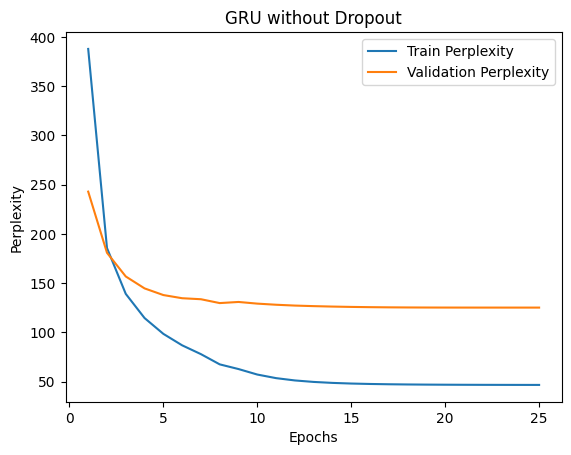


Starting experiment: GRU with Dropout
| epoch   1 |   200/ 2323 batches | lr 6.00 | ms/batch  3.31 | loss  7.05 | ppl  1151.93
| epoch   1 |   400/ 2323 batches | lr 6.00 | ms/batch  3.28 | loss  6.49 | ppl   656.63
| epoch   1 |   600/ 2323 batches | lr 6.00 | ms/batch  3.31 | loss  6.23 | ppl   509.48
| epoch   1 |   800/ 2323 batches | lr 6.00 | ms/batch  3.29 | loss  6.10 | ppl   445.05
| epoch   1 |  1000/ 2323 batches | lr 6.00 | ms/batch  3.35 | loss  5.96 | ppl   387.48
| epoch   1 |  1200/ 2323 batches | lr 6.00 | ms/batch  3.39 | loss  5.89 | ppl   362.50
| epoch   1 |  1400/ 2323 batches | lr 6.00 | ms/batch  3.40 | loss  5.74 | ppl   309.83
| epoch   1 |  1600/ 2323 batches | lr 6.00 | ms/batch  3.32 | loss  5.71 | ppl   300.77
| epoch   1 |  1800/ 2323 batches | lr 6.00 | ms/batch  3.34 | loss  5.70 | ppl   298.99
| epoch   1 |  2000/ 2323 batches | lr 6.00 | ms/batch  3.35 | loss  5.60 | ppl   269.99
| epoch   1 |  2200/ 2323 batches | lr 6.00 | ms/batch  3.36 | loss  5.

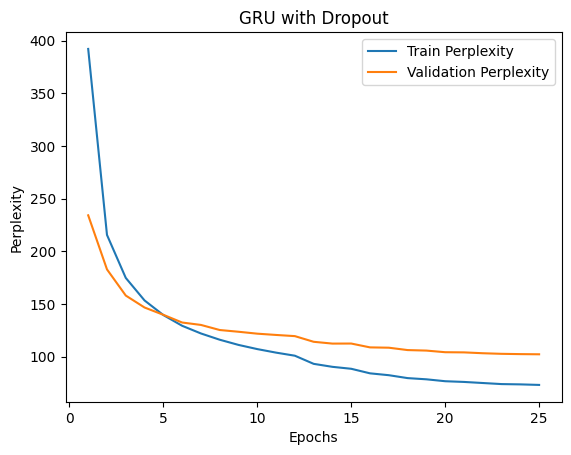

In [ ]:
# Main execution

# Experimental settings
experiments = [
    {'model_type': 'LSTM', 'dropout': 0.0, 'title': 'LSTM without Dropout'},
    {'model_type': 'LSTM', 'dropout': 0.35, 'title': 'LSTM with Dropout'},
    {'model_type': 'GRU', 'dropout': 0.0, 'title': 'GRU without Dropout'},
    {'model_type': 'GRU', 'dropout': 0.35, 'title': 'GRU with Dropout'},
]

for exp in experiments:
    lr = 4.0
    if exp['dropout']:
        lr = 6.0
    print(f"\nStarting experiment: {exp['title']}")
    model = RNNModel(exp['model_type'], vocab_size, embedding_dim, hidden_dim,
                      num_layers, dropout=exp['dropout']).to(device)
    criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    train_ppls = []
    val_ppls = []

    best_val_loss = None

    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()
        train_losses = train(model, train_data, criterion, optimizer, epoch, seq_len, lr)
        train_loss = sum(train_losses) / len(train_losses)
        val_loss = evaluate(model, valid_data, criterion, seq_len)
        train_ppl = math.exp(train_loss)
        val_ppl = math.exp(val_loss)
        train_ppls.append(train_ppl)
        val_ppls.append(val_ppl)
        print('-' * 89)
        print('| end of epoch {:3d} | time: {:5.2f}s | '
              'train loss {:5.2f} | train ppl {:8.2f} | '
              'valid loss {:5.2f} | valid ppl {:8.2f}'.format(
                epoch, (time.time() - epoch_start_time),
                train_loss, train_ppl, val_loss, val_ppl))
        print('-' * 89)

        if not best_val_loss or val_loss < best_val_loss:
            # Low improvements also decrease the learning rate
            if best_val_loss and abs(val_loss - best_val_loss) < 0.01:
                lr /= 1.5
                for param_group in optimizer.param_groups:
                    param_group['lr'] = lr
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            lr /= 1.5
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr

        if exp['dropout'] == 0.0:
            if val_ppl < 125:
                break
        elif exp['dropout'] == 0.3:
            if val_ppl < 100:
                break

    # Load the best saved model.
    model.load_state_dict(torch.load('best_model.pt'))

    # Run on test data.
    test_loss = evaluate(model, test_data, criterion, seq_len)
    test_ppl = math.exp(test_loss)
    print('=' * 89)
    print('| End of training | test loss {:5.2f} | test ppl {:8.2f}'.format(
        test_loss, test_ppl))
    print('=' * 89)

    # Plot perplexity
    plot_perplexity(train_ppls, val_ppls, exp['title'])